# Two time correlation - Duke Silica Spehers
Published in
L. Li, P. Kwasniewski, D. Oris, L Wiegart, L. Cristofolini, C. Carona and A. Fluerasu , 
"Photon statistics and speckle visibility spectroscopy with partially coherent x-rays"
J. Synchrotron Rad., vol 21, p 1288-1295, 2014.

In [1]:
from skxray.core import roi
import skxray.core.correlation as corr
from skxray.core import utils

import numpy as np
import os, sys

import xray_vision
from xray_vision.mpl_plotting import roi as roi_plot, speckle
#import xray_vision.

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm

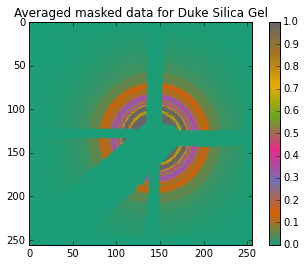

In [2]:
folder = "/Volumes/Data/BeamLines/CHX/Luxi_description_files_for_duke/Duke_data"

#  Get the data and the mask 
try:
    duke_data = np.load(os.path.join(folder, "duke_data", "duke_data.npy"))
    N_mask = np.load(os.path.join(folder, "duke_data", "N_mask.npy"))
except IOError:
    zipfile.ZipFile(os.path.join(folder, "duke_data.zip")).extractall()
    duke_data = np.load(os.path.join(folder, "duke_data", "duke_data.npy"))
    N_mask = np.load(os.path.join(folder, "duke_data", "N_mask.npy"))

#  get the average image
avg_img = np.average(duke_data, axis=0)

# plot the average image data after masking
plt.figure()
plt.imshow(N_mask*avg_img, vmax=1e0, cmap="Dark2" )
plt.title("Averaged masked data for Duke Silica Gel ")
plt.colorbar()
plt.show()


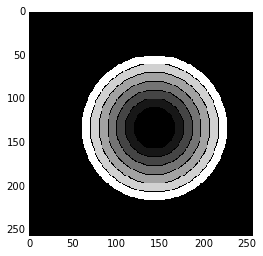

In [3]:
inner_radius = 24
width = 9
spacing = 1
num_rings = 6

edges = roi.ring_edges(inner_radius, width, spacing, num_rings)

rings = roi.rings(edges, (133, 143), avg_img.shape)

rings_mask = rings*N_mask

fig, ax = plt.subplots()
roi_plot.show_label_array(ax, rings, cmap="gray")
plt.show()

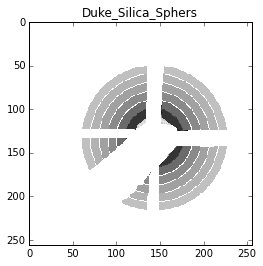

In [4]:
fig, ax = plt.subplots()
plt.title("Duke_Silica_Sphers")
roi_plot.show_label_array_on_image(ax, avg_img*N_mask, rings_mask, cmap='gray')
plt.show()

In [5]:
import numpy.ma as ma
import logging
import time

import skxray.core as core
logger = logging.getLogger(__name__)

def two_time(num_levels, num_bufs, labels, images):
    """
    This function computes two-time correlations.
    It uses a scheme to achieve long-time correlations inexpensively
    by downsampling the data, iteratively combining successive frames.
    The longest lag time computed is num_levels * num_bufs.
    ** see comments on multi_tau_auto_corr
    Parameters
    ----------
    num_levels : int
        how many generations of downsampling to perform, i.e.,
        the depth of the binomial tree of averaged frames
    num_bufs : int, must be even
        maximum lag step to compute in each generation of
        downsampling
    labels : array
        labeled array of the same shape as the image stack;
        each ROI is represented by a distinct label (i.e., integer)
    images : array
        dimensions are: (rr, cc), iterable of 2D arrays
    Returns
    -------
    two_time_c : array
        matrix of two_time correlation
        shape (number of images, number of images, number of labels(ROI))
    """

    label_mask, pixel_list, num_rois, num_pixels = _validate_inputs(num_bufs,
                                                                    labels,
                                                                    images)

    # Ring buffer, a buffer with periodic boundary conditions.
    # Images must be keep for up to maximum delay in buf.
    buf = np.zeros((num_levels, num_bufs, np.sum(num_pixels)),
                   dtype=np.float64)

    # to track processing each level
    track_level = np.zeros(num_levels)

    # to increment buffer
    cur = np.ones(num_levels, dtype=np.int64)

    # to track how many images processed in each level
    img_per_level = np.zeros(num_levels, dtype=np.int64)

    # two time correlation results
    two_time_c = np.zeros((images.operands[0].shape[0],
                           images.operands[0].shape[0], num_rois),
                          dtype=np.float64)

    # to count images in each level
    count_level = np.zeros(num_levels, dtype=np.int64)

    # generate a time frame for each level
    time_ind = {key: [] for key in range(num_levels)}

    start_time = time.time()  # used to log the computation time (optionally)
    #  for two time correlation

    tot_channels, lag_steps = utils.multi_tau_lags(num_levels, num_bufs)

    for n, img in enumerate(images.operands[0]):
        cur[0] = (1 + cur[0]) % num_bufs  # increment buffer

        count_level[0] = 1 + count_level[0]
        # current image number
        current_img_time = n + 1
        print "curent_img_time1", current_img_time

        # Put the image into the ring buffer.
        buf[0, cur[0] - 1] = (np.ravel(img))[pixel_list]

        # Compute the two time correlations between the first level
        # (undownsampled) frames. two_time_c and img_per_level in place!
        _two_time_process(buf, two_time_c, label_mask, num_bufs, num_pixels,
                          img_per_level, lag_steps, current_img_time, level=0,
                          buf_no=cur[0] - 1)

        # time frame for each level
        time_ind[0].append(current_img_time)

        # check whether the number of levels is one, otherwise
        # continue processing the next level
        processing = num_levels > 1

        # Compute the correlations for all higher levels.
        level = 1
        while processing:
            if not track_level[level]:
                track_level[level] = 1
                processing = False
            else:
                prev = 1 + (cur[level - 1] - 2) % num_bufs
                cur[level] = 1 + cur[level] % num_bufs
                count_level[level] = 1 + count_level[level]

                buf[level, cur[level] - 1] = (buf[level - 1, prev - 1] +
                                              buf[level - 1,
                                                  cur[level - 1] - 1])/2

                t1_idx = (count_level[level] - 1) * 2

                current_img_time = ((time_ind[level - 1])[t1_idx]
                                    + (time_ind[level - 1])[t1_idx + 1])/2.
                
                print "current_img_time",current_img_time

                # time frame for each level
                time_ind[level].append(current_img_time)

                # make the track_level zero once that level is processed
                track_level[level] = 0

                # call the _two_time_process function for each multi-tau level
                # for multi-tau levels greater than one
                # Again, this is modifying things in place. See comment
                # on previous call above.
                _two_time_process(buf, two_time_c, label_mask, num_bufs,
                                  num_pixels, img_per_level, lag_steps,
                                  current_img_time, level=level,
                                  buf_no=cur[level]-1)
                level += 1

                # Checking whether there is next level for processing
                processing = level < num_levels

    for q in range(np.max(labels)):
        x0 = two_time_c[:, :, q]
        two_time_c[:, :, q] = (np.tril(x0) + np.tril(x0).T
                               - np.diag(np.diag(x0)))

    # ending time for the two time correlation
    end_time = time.time()

    logger.info("Two Time Correlation - Processing time for {0} images took"
                " {1} seconds." .format(n, (end_time - start_time)))

    return two_time_c

def _two_time_process(buf, two_time_c, label_mask, num_bufs, num_pixels,
                      img_per_level, lag_steps, current_img_time, level,
                      buf_no):
    """
    Parameters
    ----------
    buf: array
        image data array to use for two time correlation
    two_time_c: array
        two time correlation matrix
    label_mask: array
        Elements not inside any ROI are zero; elements inside each
        ROI are 1, 2, 3, etc. corresponding to the order they are specified
        in edges and segments
    num_bufs: int, even
        number of buffers(channels)
    num_pixels : array
        number of pixels in certain roi's
        roi's, dimensions are : [number of roi's]
    img_per_level: array
        to track how many images processed in each level
    lag_steps : array
        delay or lag steps for the multiple tau analysis
        shape num_levels
    current_img_time : int
        the current image number
    level : int
        the current multi-tau level
    buf_no : int
        the current buffer number
    """
    img_per_level[level] += 1

    # in multi-tau correlation other than first level all other levels
    #  have to do the half of the correlation
    if level == 0:
        i_min = 0
    else:
        i_min = num_bufs//2

    for i in range(i_min, min(img_per_level[level], num_bufs)):
        (t_index, tmp_binned, pi_binned,
         fi_binned) = _help_process(level, num_bufs, buf_no, i, buf,
                                    label_mask)

        tind1 = (current_img_time - 1)

        tind2 = (current_img_time - lag_steps[t_index] - 1)

        if not isinstance(current_img_time, int):
            nshift = 2**(level-1)
            for i in range(-nshift+1, nshift+1):
                two_time_c[int(tind1+i),
                           int(tind2+i)] = (tmp_binned/(pi_binned *
                                                        fi_binned))*num_pixels
        else:
            two_time_c[tind1, tind2] = tmp_binned/(pi_binned *
                                                   fi_binned)*num_pixels
    return None


def _help_process(level, num_bufs, buf_no, i, buf, label_mask):
    """
    This is a helper function for both one time and two time correlation
    process functions.
    Parameters
    ----------
    level : int
        the current multi-tau level
    num_bufs : int
        number of buffers(channels)
    buf_no : int
        the current buffer number
    i : int
    buf : array
        image data array to use for two time correlation
    label_mask: array
        Elements not inside any ROI are zero; elements inside each
        ROI are 1, 2, 3, etc. corresponding to the order they are specified
        in edges and segments
    Returns
    -------
    t_index : float
        time
    tmp_binned : array
        matrix of correlation function without normalizations
    pi_binned : array
        matrix of past intensity normalizations
    fi_binned : array
        matrix of future intensity normalizations
    """
    t_index = level*num_bufs/2 + i

    delay_no = (buf_no - i) % num_bufs

    past_img = buf[level, delay_no]
    future_img = buf[level, buf_no]

    #  get the matrix of correlation function without normalizations
    tmp_binned = (np.bincount(label_mask,
                              weights=past_img*future_img)[1:])
    # get the matrix of past intensity normalizations
    pi_binned = (np.bincount(label_mask,
                             weights=past_img)[1:])

    # get the matrix of future intensity normalizations
    fi_binned = (np.bincount(label_mask,
                             weights=future_img)[1:])
    return t_index, tmp_binned, pi_binned, fi_binned


def _validate_inputs(num_bufs, labels, images):
    """
    This is a helper function to validate inputs for both one time and
    two time correlation
    Parameters
    ----------
    num_bufs : int, must be even
        maximum lag step to compute in each generation of
        downsampling
    labels : array
        labeled array of the same shape as the image stack;
        each ROI is represented by a distinct label (i.e., integer)
    images : iterable of 2D arrays
        dimensions are: (rr, cc)
    Returns
    -------
    label_mask : array
        labels of the required region of interests(ROI's)
    indices : array
        1D array of indices into the raveled image for all
        foreground pixels (labeled nonzero)
        e.g., [5, 6, 7, 8, 14, 15, 21, 22]
    num_rois : array
        number of ROI's
    num_pixels : array
        number of pixels in each ROI's
    """
    if num_bufs % 2 != 0:
        raise ValueError("number of channels(number of buffers) in "
                         "multiple-taus (must be even)")

    if labels.shape != images.operands[0].shape[1:]:
        raise ValueError("Shape of the image stack should be equal to"
                         " shape of the labels array")

    # get the pixels in each label
    label_mask, indices = roi.extract_label_indices(labels)

    num_rois = np.max(label_mask)

    # number of pixels per ROI
    num_pixels = np.bincount(label_mask, minlength=(num_rois+1))
    num_pixels = num_pixels[1:]

    if np.any(num_pixels == 0):
        raise ValueError("Number of pixels of the required roi's"
                         " cannot be zero, "
                         "num_pixels = {0}".format(num_pixels))

    return label_mask, indices, num_rois, num_pixels

In [6]:
images= N_mask*duke_data
images.shape

(5000, 256, 256)

In [7]:
img_it = np.nditer(images)

num_levels = 20
num_bufs = 8

two_time_c = two_time(num_levels, num_bufs, rings_mask, img_it)

curent_img_time1 1
curent_img_time1 2
current_img_time 1.5
curent_img_time1 3
curent_img_time1 4
current_img_time 3.5
current_img_time 2.5
curent_img_time1 5
curent_img_time1 6
current_img_time 5.5
curent_img_time1 7
curent_img_time1 8
current_img_time 7.5
current_img_time 6.5
current_img_time 4.5
curent_img_time1 9
curent_img_time1 10
current_img_time 9.5
curent_img_time1 11
curent_img_time1 12
current_img_time 11.5
current_img_time 10.5
curent_img_time1 13
curent_img_time1 14
current_img_time 13.5
curent_img_time1 15
curent_img_time1 16
current_img_time 15.5
current_img_time 14.5
current_img_time 12.5
current_img_time 8.5
curent_img_time1 17
curent_img_time1 18
current_img_time 17.5
curent_img_time1 19
curent_img_time1 20
current_img_time 19.5
current_img_time 18.5
curent_img_time1 21
curent_img_time1 22
current_img_time 21.5
curent_img_time1 23
curent_img_time1 24
current_img_time 23.5
current_img_time 22.5
current_img_time 20.5
curent_img_time1 25
curent_img_time1 26
current_img_ti

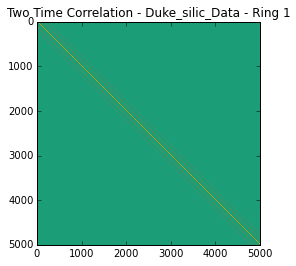

In [23]:
plt.imshow(two_time_c[:,:,0], cmap='Dark2')
plt.title("Two Time Correlation - Duke_silic_Data - Ring 1")
plt.show()

In [15]:
from skimage import data
num_levels = 1
num_bufs = 2  # must be even
coins = data.camera()
coins_stack = []

for i in range(4):
    coins_stack.append(coins)

coins_mesh = np.zeros_like(coins)
coins_mesh[coins < 30] = 1
coins_mesh[coins > 50] = 2

g2, lag_steps = corr.multi_tau_auto_corr(num_levels, num_bufs, coins_mesh,
                                             coins_stack)

#assert_almost_equal(True, np.all(g2[:, 0], axis=0))
#assert_almost_equal(True, np.all(g2[:, 1], axis=0))

In [18]:
coins_it = np.nditer(coins_stack)
coins_it

In [19]:
two_time_coins = two_time(num_levels=2, num_bufs=6,
                                   labels=coins_mesh, images=coins_it)

ValueError: Shape of the image stack should be equal to shape of the labels array

In [23]:
coins_it.operands[1].shape

(512, 512)

In [22]:
coins_mesh.shape

(512, 512)

In [43]:
def two_time_n(num_levels, num_bufs, labels, images):
    """
    This function computes two-time correlations.
    two_time_corr Original code : @author: Yugang Zhang

    It uses a scheme to achieve long-time correlations inexpensively
    by downsampling the data, iteratively combining successive frames.

    The longest lag time computed is num_levels * num_bufs.
    ** see comments on multi_tau_auto_corr

    Parameters
    ----------
    num_levels : int
        how many generations of downsampling to perform, i.e.,
        the depth of the binomial tree of averaged frames

    num_bufs : int, must be even
        maximum lag step to compute in each generation of
        downsampling

    labels : array
        labeled array of the same shape as the image stack;
        each ROI is represented by a distinct label (i.e., integer)

    images : array
        dimensions are: (rr, cc), iterable of 2D arrays

    Returns
    -------
    two_time_c : array
        matrix of two_time correlation
        shape (number of images, number of images, number of labels(ROI))

    Notes
    -----
    The two-time correlation function is defined as

    :math ::
        C(q, t_1, t_2) = \frac{<I(q, t_1)I(q, t_2)>_pix }{<I(q, t_1)>_pix <I(q, t_2)>_pix}

    Here, the ensemble averages are performed over many pixels of detector,
    all having the same q value. The average time or age is equal to (t1+t2)/2,
    measured by the distance along the t1 = t2 diagonal.
    The time difference t = |t1 - t2|, with is distance from the t1 = t2
    diagonal in the perpendicular direction.
    In the equilibrium system, the two-time correlation functions depend only
    on the time difference t, and hence the two-time correlation contour lines
    are parallel.

    References
    ----------

    .. [1] A. Fluerasu, A. Moussaid, A. Mandsen and A. Schofield,
        "Slow dynamics and aging in collodial gels studied by x-ray photon
         correlation spectroscopy," Phys. Rev. E., vol 76, p 010401(1-4), 2007.
    """

    label_mask, pixel_list, num_rois, num_pixels = _validate_inputs(num_bufs,
                                                                    labels,
                                                                    images)

    # Ring buffer, a buffer with periodic boundary conditions.
    # Images must be keep for up to maximum delay in buf.
    buf = np.zeros((num_levels, num_bufs, np.sum(num_pixels)),
                   dtype=np.float64)

    # to track processing each level
    track_level = np.zeros(num_levels)

    # to increment buffer
    cur = np.ones(num_levels, dtype=np.int64)

    # to track how many images processed in each level
    img_per_level = np.zeros(num_levels, dtype=np.int64)

    # two time correlation results
    #two_time_c = np.zeros((images.operands[0].shape[0],    ???
    #                       images.operands[0].shape[0], num_rois), ???
    #                      dtype=np.float64)???
    two_time_c = np.zeros((images[0].shape[0],
                           images[0].shape[0], num_rois),
                          dtype=np.float64)

    # to count images in each level
    count_level = np.zeros(num_levels, dtype=np.int64)

    # generate a time frame for each level
    time_ind = {key: [] for key in range(num_levels)}

    start_time = time.time()  # used to log the computation time (optionally)
    #  for two time correlation

    tot_channels, lag_steps = utils.multi_tau_lags(num_levels, num_bufs)

    #for n, img in enumerate(images.operands[0]):   ???
    for n, img in enumerate(images):
        cur[0] = (1 + cur[0]) % num_bufs  # increment buffer

        count_level[0] = 1 + count_level[0]
        # current image number
        current_img_time = n + 1
        print "c_img_time 1", current_img_time

        # Put the image into the ring buffer.
        buf[0, cur[0] - 1] = (np.ravel(img))[pixel_list]

        # Compute the two time correlations between the first level
        # (undownsampled) frames. two_time_c and img_per_level in place!
        _two_time_process(buf, two_time_c, label_mask, num_bufs, num_pixels,
                          img_per_level, lag_steps, current_img_time, level=0,
                          buf_no=cur[0] - 1)

        # time frame for each level
        time_ind[0].append(current_img_time)

        # Compute the correlations for all higher levels.
        # if the num_levels is more than one
        level = 1
        while level < num_levels:
            if not track_level[level]:
                track_level[level] = 1
            else:
                prev = 1 + (cur[level - 1] - 2) % num_bufs
                cur[level] = 1 + cur[level] % num_bufs
                count_level[level] = 1 + count_level[level]

                buf[level, cur[level] - 1] = (buf[level - 1, prev - 1] +
                                              buf[level - 1,
                                                  cur[level - 1] - 1])/2

                t1_idx = (count_level[level] - 1) * 2

                current_img_time = ((time_ind[level - 1])[t1_idx]
                                    + (time_ind[level - 1])[t1_idx + 1])/2.
                print "c_img_time ", current_img_time

                # time frame for each level
                time_ind[level].append(current_img_time)

                # make the track_level zero once that level is processed
                track_level[level] = 0

                # call the _two_time_process function for each multi-tau level
                # for multi-tau levels greater than one
                # Again, this is modifying things in place. See comment
                # on previous call above.
                _two_time_process(buf, two_time_c, label_mask, num_bufs,
                                  num_pixels, img_per_level, lag_steps,
                                  current_img_time, level=level,
                                  buf_no=cur[level]-1)
                level += 1

    for q in range(np.max(labels)):
        x0 = two_time_c[:, :, q]
        two_time_c[:, :, q] = (np.tril(x0) + np.tril(x0).T
                               - np.diag(np.diag(x0)))
    # Two time correlation processing time
    logger.info("Two Time Correlation - Processing time for {0} images took"
                " {1} seconds." .format(n, (time.time() - start_time)))

    return two_time_c


def _two_time_process(buf, two_time_c, label_mask, num_bufs, num_pixels,
                      img_per_level, lag_steps, current_img_time, level,
                      buf_no):
    """
    Parameters
    ----------
    buf: array
        image data array to use for two time correlation

    two_time_c: array
        two time correlation matrix

    label_mask: array
        Elements not inside any ROI are zero; elements inside each
        ROI are 1, 2, 3, etc. corresponding to the order they are specified
        in edges and segments

    num_bufs: int, even
        number of buffers(channels)

    num_pixels : array
        number of pixels in certain roi's
        roi's, dimensions are : [number of roi's]

    img_per_level: array
        to track how many images processed in each level

    lag_steps : array
        delay or lag steps for the multiple tau analysis
        shape num_levels

    current_img_time : int
        the current image number

    level : int
        the current multi-tau level

    buf_no : int
        the current buffer number

    """
    img_per_level[level] += 1

    # in multi-tau correlation other than first level all other levels
    #  have to do the half of the correlation
    if level == 0:
        i_min = 0
    else:
        i_min = num_bufs//2

    for i in range(i_min, min(img_per_level[level], num_bufs)):
        (t_index, tmp_binned, pi_binned,
         fi_binned) = _help_process(level, num_bufs, buf_no, i, buf,
                                    label_mask)

        tind1 = (current_img_time - 1)

        tind2 = (current_img_time - lag_steps[t_index] - 1)

        if not isinstance(current_img_time, int):
            nshift = 2**(level-1)
            for i in range(-nshift+1, nshift+1):
                two_time_c[int(tind1+i),
                           int(tind2+i)] = (tmp_binned/(pi_binned *
                                                        fi_binned))*num_pixels
        else:
            two_time_c[tind1, tind2] = tmp_binned/(pi_binned *
                                                   fi_binned)*num_pixels


def _help_process(level, num_bufs, buf_no, i, buf, label_mask):
    """
    This is a helper function for both one time and two time correlation
    process functions.

    Parameters
    ----------
    level : int
        the current multi-tau level

    num_bufs : int
        number of buffers(channels)

    buf_no : int
        the current buffer number

    i : int

    buf : array
        image data array to use for two time correlation

    label_mask: array
        Elements not inside any ROI are zero; elements inside each
        ROI are 1, 2, 3, etc. corresponding to the order they are specified
        in edges and segments

    Returns
    -------
    t_index : float
        time

    tmp_binned : array
        matrix of correlation function without normalizations

    pi_binned : array
        matrix of past intensity normalizations

    fi_binned : array
        matrix of future intensity normalizations
    """
    t_index = level*num_bufs/2 + i

    delay_no = (buf_no - i) % num_bufs

    past_img = buf[level, delay_no]
    future_img = buf[level, buf_no]

    #  get the matrix of correlation function without normalizations
    tmp_binned = (np.bincount(label_mask,
                              weights=past_img*future_img)[1:])
    # get the matrix of past intensity normalizations
    pi_binned = (np.bincount(label_mask,
                             weights=past_img)[1:])

    # get the matrix of future intensity normalizations
    fi_binned = (np.bincount(label_mask,
                             weights=future_img)[1:])
    return t_index, tmp_binned, pi_binned, fi_binned


def _validate_inputs(num_bufs, labels, images):
    """
    This is a helper function to validate inputs for both one time and
    two time correlation

    Parameters
    ----------
    num_bufs : int, must be even
        maximum lag step to compute in each generation of
        downsampling

    labels : array
        labeled array of the same shape as the image stack;
        each ROI is represented by a distinct label (i.e., integer)

    images : iterable of 2D arrays
        dimensions are: (rr, cc)

    Returns
    -------
    label_mask : array
        labels of the required region of interests(ROI's)

    indices : array
        1D array of indices into the raveled image for all
        foreground pixels (labeled nonzero)
        e.g., [5, 6, 7, 8, 14, 15, 21, 22]

    num_rois : array
        number of ROI's

    num_pixels : array
        number of pixels in each ROI's
    """
    if num_bufs % 2 != 0:
        raise ValueError("number of channels(number of buffers) in "
                         "multiple-taus (must be even)")

    if hasattr(images, 'frame_shape'):
        # Give a user-friendly error if we can detect the shape from pims.
        if labels.shape != images.frame_shape:
            raise ValueError("Shape of the images should be equal to"
                             " shape of the labels array")

    # get the pixels in each label
    label_mask, indices = roi.extract_label_indices(labels)

    num_rois = np.max(label_mask)

    # number of pixels per ROI
    num_pixels = np.bincount(label_mask, minlength=(num_rois+1))
    num_pixels = num_pixels[1:]

    if np.any(num_pixels == 0):
        raise ValueError("Number of pixels of the required roi's"
                         " cannot be zero, "
                         "num_pixels = {0}".format(num_pixels))

    return label_mask, indices, num_rois, num_pixels


In [44]:
num_levels=1
two_time_coins = two_time_n(num_levels=2, num_bufs=6,
                                   labels=coins_mesh, images=coins_stack)

c_img_time 1 1


IndexError: list index out of range

In [34]:
def two_time_c(num_levels, num_bufs, labels, images):
    """
    This function computes two-time correlations.
    It uses a scheme to achieve long-time correlations inexpensively
    by downsampling the data, iteratively combining successive frames.
    The longest lag time computed is num_levels * num_bufs.
    ** see comments on multi_tau_auto_corr
    Parameters
    ----------
    num_levels : int
        how many generations of downsampling to perform, i.e.,
        the depth of the binomial tree of averaged frames
    num_bufs : int, must be even
        maximum lag step to compute in each generation of
        downsampling
    labels : array
        labeled array of the same shape as the image stack;
        each ROI is represented by a distinct label (i.e., integer)
    images : array
        dimensions are: (rr, cc), iterable of 2D arrays
    Returns
    -------
    two_time_c : array
        matrix of two_time correlation
        shape (number of images, number of images, number of labels(ROI))
    """

    label_mask, pixel_list, num_rois, num_pixels = _validate_inputs(num_bufs,
                                                                    labels,
                                                                    images)

    # Ring buffer, a buffer with periodic boundary conditions.
    # Images must be keep for up to maximum delay in buf.
    buf = np.zeros((num_levels, num_bufs, np.sum(num_pixels)),
                   dtype=np.float64)

    # to track processing each level
    track_level = np.zeros(num_levels)

    # to increment buffer
    cur = np.ones(num_levels, dtype=np.int64)

    # to track how many images processed in each level
    img_per_level = np.zeros(num_levels, dtype=np.int64)

    # two time correlation results
    two_time_c = np.zeros((images.operands[0].shape[0],
                           images.operands[0].shape[0], num_rois),
                          dtype=np.float64)

    # to count images in each level
    count_level = np.zeros(num_levels, dtype=np.int64)

    # generate a time frame for each level
    time_ind = {key: [] for key in range(num_levels)}

    start_time = time.time()  # used to log the computation time (optionally)
    #  for two time correlation

    tot_channels, lag_steps = utils.multi_tau_lags(num_levels, num_bufs)

    for n, img in enumerate(images.operands[0]):
        cur[0] = (1 + cur[0]) % num_bufs  # increment buffer

        count_level[0] = 1 + count_level[0]
        # current image number
        current_img_time = n + 1
        print "curent_img_time1", current_img_time

        # Put the image into the ring buffer.
        buf[0, cur[0] - 1] = (np.ravel(img))[pixel_list]

        # Compute the two time correlations between the first level
        # (undownsampled) frames. two_time_c and img_per_level in place!
        _two_time_process(buf, two_time_c, label_mask, num_bufs, num_pixels,
                          img_per_level, lag_steps, current_img_time, level=0,
                          buf_no=cur[0] - 1)

        # time frame for each level
        time_ind[0].append(current_img_time)

        # check whether the number of levels is one, otherwise
        # continue processing the next level
        # processing = num_levels > 1

        # Compute the correlations for all higher levels.
        level = 1
        while level<num_levels:
            if not track_level[level]:
                track_level[level] = 1
                # processing = False
            else:
                prev = 1 + (cur[level - 1] - 2) % num_bufs
                cur[level] = 1 + cur[level] % num_bufs
                count_level[level] = 1 + count_level[level]

                buf[level, cur[level] - 1] = (buf[level - 1, prev - 1] +
                                              buf[level - 1,
                                                  cur[level - 1] - 1])/2

                t1_idx = (count_level[level] - 1) * 2

                current_img_time = ((time_ind[level - 1])[t1_idx]
                                    + (time_ind[level - 1])[t1_idx + 1])/2.
                
                print "current_img_time",current_img_time

                # time frame for each level
                time_ind[level].append(current_img_time)

                # make the track_level zero once that level is processed
                track_level[level] = 0

                # call the _two_time_process function for each multi-tau level
                # for multi-tau levels greater than one
                # Again, this is modifying things in place. See comment
                # on previous call above.
                _two_time_process(buf, two_time_c, label_mask, num_bufs,
                                  num_pixels, img_per_level, lag_steps,
                                  current_img_time, level=level,
                                  buf_no=cur[level]-1)
                level += 1

                # Checking whether there is next level for processing
                #processing = level < num_levels

    for q in range(np.max(labels)):
        x0 = two_time_c[:, :, q]
        two_time_c[:, :, q] = (np.tril(x0) + np.tril(x0).T
                               - np.diag(np.diag(x0)))

    # ending time for the two time correlation
    end_time = time.time()

    logger.info("Two Time Correlation - Processing time for {0} images took"
                " {1} seconds." .format(n, (end_time - start_time)))

    return two_time_c

def _two_time_process(buf, two_time_c, label_mask, num_bufs, num_pixels,
                      img_per_level, lag_steps, current_img_time, level,
                      buf_no):
    """
    Parameters
    ----------
    buf: array
        image data array to use for two time correlation
    two_time_c: array
        two time correlation matrix
    label_mask: array
        Elements not inside any ROI are zero; elements inside each
        ROI are 1, 2, 3, etc. corresponding to the order they are specified
        in edges and segments
    num_bufs: int, even
        number of buffers(channels)
    num_pixels : array
        number of pixels in certain roi's
        roi's, dimensions are : [number of roi's]
    img_per_level: array
        to track how many images processed in each level
    lag_steps : array
        delay or lag steps for the multiple tau analysis
        shape num_levels
    current_img_time : int
        the current image number
    level : int
        the current multi-tau level
    buf_no : int
        the current buffer number
    """
    img_per_level[level] += 1

    # in multi-tau correlation other than first level all other levels
    #  have to do the half of the correlation
    if level == 0:
        i_min = 0
    else:
        i_min = num_bufs//2

    for i in range(i_min, min(img_per_level[level], num_bufs)):
        (t_index, tmp_binned, pi_binned,
         fi_binned) = _help_process(level, num_bufs, buf_no, i, buf,
                                    label_mask)

        tind1 = (current_img_time - 1)

        tind2 = (current_img_time - lag_steps[t_index] - 1)

        if not isinstance(current_img_time, int):
            nshift = 2**(level-1)
            for i in range(-nshift+1, nshift+1):
                two_time_c[int(tind1+i),
                           int(tind2+i)] = (tmp_binned/(pi_binned *
                                                        fi_binned))*num_pixels
        else:
            two_time_c[tind1, tind2] = tmp_binned/(pi_binned *
                                                   fi_binned)*num_pixels
    return None


def _help_process(level, num_bufs, buf_no, i, buf, label_mask):
    """
    This is a helper function for both one time and two time correlation
    process functions.
    Parameters
    ----------
    level : int
        the current multi-tau level
    num_bufs : int
        number of buffers(channels)
    buf_no : int
        the current buffer number
    i : int
    buf : array
        image data array to use for two time correlation
    label_mask: array
        Elements not inside any ROI are zero; elements inside each
        ROI are 1, 2, 3, etc. corresponding to the order they are specified
        in edges and segments
    Returns
    -------
    t_index : float
        time
    tmp_binned : array
        matrix of correlation function without normalizations
    pi_binned : array
        matrix of past intensity normalizations
    fi_binned : array
        matrix of future intensity normalizations
    """
    t_index = level*num_bufs/2 + i

    delay_no = (buf_no - i) % num_bufs

    past_img = buf[level, delay_no]
    future_img = buf[level, buf_no]

    #  get the matrix of correlation function without normalizations
    tmp_binned = (np.bincount(label_mask,
                              weights=past_img*future_img)[1:])
    # get the matrix of past intensity normalizations
    pi_binned = (np.bincount(label_mask,
                             weights=past_img)[1:])

    # get the matrix of future intensity normalizations
    fi_binned = (np.bincount(label_mask,
                             weights=future_img)[1:])
    return t_index, tmp_binned, pi_binned, fi_binned


def _validate_inputs(num_bufs, labels, images):
    """
    This is a helper function to validate inputs for both one time and
    two time correlation
    Parameters
    ----------
    num_bufs : int, must be even
        maximum lag step to compute in each generation of
        downsampling
    labels : array
        labeled array of the same shape as the image stack;
        each ROI is represented by a distinct label (i.e., integer)
    images : iterable of 2D arrays
        dimensions are: (rr, cc)
    Returns
    -------
    label_mask : array
        labels of the required region of interests(ROI's)
    indices : array
        1D array of indices into the raveled image for all
        foreground pixels (labeled nonzero)
        e.g., [5, 6, 7, 8, 14, 15, 21, 22]
    num_rois : array
        number of ROI's
    num_pixels : array
        number of pixels in each ROI's
    """
    if num_bufs % 2 != 0:
        raise ValueError("number of channels(number of buffers) in "
                         "multiple-taus (must be even)")

    if labels.shape != images.operands[0].shape[1:]:
        raise ValueError("Shape of the image stack should be equal to"
                         " shape of the labels array")

    # get the pixels in each label
    label_mask, indices = roi.extract_label_indices(labels)

    num_rois = np.max(label_mask)

    # number of pixels per ROI
    num_pixels = np.bincount(label_mask, minlength=(num_rois+1))
    num_pixels = num_pixels[1:]

    if np.any(num_pixels == 0):
        raise ValueError("Number of pixels of the required roi's"
                         " cannot be zero, "
                         "num_pixels = {0}".format(num_pixels))

    return label_mask, indices, num_rois, num_pixels

In [35]:

two_time_c = two_time_c(num_levels, num_bufs, rings_mask, img_it)

curent_img_time1 1
curent_img_time1 2
curent_img_time1 3
curent_img_time1 4
curent_img_time1 5
curent_img_time1 6
curent_img_time1 7
curent_img_time1 8
curent_img_time1 9
curent_img_time1 10
curent_img_time1 11
curent_img_time1 12
curent_img_time1 13
curent_img_time1 14
curent_img_time1 15
curent_img_time1 16
curent_img_time1 17
curent_img_time1 18
curent_img_time1 19
curent_img_time1 20
curent_img_time1 21
curent_img_time1 22
curent_img_time1 23
curent_img_time1 24
curent_img_time1 25
curent_img_time1 26
curent_img_time1 27
curent_img_time1 28
curent_img_time1 29
curent_img_time1 30
curent_img_time1 31
curent_img_time1 32
curent_img_time1 33
curent_img_time1 34
curent_img_time1 35
curent_img_time1 36
curent_img_time1 37
curent_img_time1 38
curent_img_time1 39
curent_img_time1 40
curent_img_time1 41
curent_img_time1 42
curent_img_time1 43
curent_img_time1 44
curent_img_time1 45
curent_img_time1 46
curent_img_time1 47
curent_img_time1 48
curent_img_time1 49
curent_img_time1 50
curent_im

In [8]:
num_levels = 2
img_it

In [9]:
rings_mask.shape

(256, 256)

In [10]:
two_time_c = two_time_c(num_levels, num_bufs, rings_mask, img_it)

TypeError: 'numpy.ndarray' object is not callable